This notebook trains a manual Vector Autoregressive Model with exogenous variables for conditional forecasting. The previous VARX model notebook used a single built in object from statsmodels, which uses every exogenous variable in every equation. However, it is unlikely that most of the exogenous variables are truly significant for every dependent variable. For example, there could be a weak relationship between coin five's outcome with coin eleven's opening price the previous minute. Therefore, to investigate a more tailored approach for each coin, separate equations can be built and combined into a VARX model with different exogenous variables for each coin.

The data transformations and preparation are used from the Data-Transformations notebook.

## Import Packages

In [1]:
import gresearch_crypto

from datetime import datetime
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import gc
import numpy as np
import pandas as pd
import sys

## Declare variables

In [2]:
train_filepath = '/kaggle/input/g-research-crypto-forecasting/train.csv'
asset_details_filepath = '/kaggle/input/g-research-crypto-forecasting/asset_details.csv'

## Declare Cleaning Functions

In [3]:
def clean_dates(df):
    '''
    Function to clean timestamps of an individual coin 
    by the earliest and latest timestamps observed for that coin.
    Also fills in missing values by the method chosen for the interpolate function.
    
    Inputs: 
        df (pd.DataFrame.GroupBy object) :
            Grouped Dataframe by unique coins. All timestamps must be
            in intervals of 60 seconds.

    Outputs:
        constant_dates_df (pd.DataFrame) :
            Dataframe with timestamps and filled missing values.
    '''
    
    df = df.copy()
    
    dates = range(min(df["timestamp"]), max(df["timestamp"]), 60)
    
    df.set_index("timestamp", inplace = True)
    
    df = df.reindex(dates)
    
    # replace the 9 infinite values with NaN, which are interpolated in the next line
    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    
    # don't fill missing values at end of dataset, where they do not
    # have ending observations to interpolate with
    df.interpolate(method = "linear", inplace = True, limit_area = "inside")
    
    return df
    
def standardize_data(df):
    '''
    Function to standardize data by creating rows for every timestamp
    and subsetting to only consider when all coins had their first observation made.
    
    Inputs:
        df (pd.DataFrame) :
            Time series data to be standardized
            
    Outputs:
        standard_df (pd.DataFrame) :
            Time series data now standardized
    '''
    
    # deep copy to not alter the original
    df = df.copy()
    
    # fill missing rows / values between coin's start and stop date
    # Note: Missing rows beyond an individual coin's start / stop date are not created,
    # only those between are filled in
    standard_df = df.groupby("Asset_ID").apply(clean_dates).reset_index(level = 0, drop = True)
    
    # reset twice so timestamp is only a column and not also index, 
    # this makes each entry have a unique index
    standard_df = standard_df.reset_index()
    
    # get the earliest timestamp for each coin, then get the latest timestamp out of those.
    # this shows when the latest coin was introduced, after which there are observations for
    # all coins
    first_timestamp = max(standard_df.groupby("Asset_ID")["timestamp"].min())
    
    # subset to only consider the time period where observations existed for all coins
    standard_df = standard_df.loc[standard_df["timestamp"] >= first_timestamp]
    
    # drop ending rows with missing values
    standard_df.dropna(inplace = True)
    
    # convert to int to better reflect nature of data
    standard_df["Count"] = standard_df["Count"].astype("int")
    standard_df["Asset_ID"] = standard_df["Asset_ID"].astype("int")
    
    return standard_df

def df_long_to_wide(df, group_column, cols_to_keep, time_col):
    '''
    Function to transform data from long to wide format.
    
    Assumes passed DataFrame is in long format, where each row corresponds to
    a unique observation in cross section and in time (i.e. the values of a specific
    coin at a specific time)
    
    Returns a formatted DataFrame in wide format, where each row corresponds only 
    to a unique time. 
    
    Inputs:
        df (pd.DataFrame) :
            Time series data in long format
            
        group_column (str) :
            String of the column to be grouped by, representing
            the cross sectional identifier of the data 
            (e.g. identifier for which coin out of 14 
            cryptocurrencies the row represents)
            
        cols_to_keep (list of strs) :
            List of strings, where each string represents a column
            to keep and include in the new wide dataframe. Each column
            will be repeated for each group (e.g. for two groups and
            three columns, each row will have six appended columns
            in the wide df) 
            
        time_col (str) :
            String of the column that contains time information
            
    Outputs:
        wide_df (pd.DataFrame) :
            Time series data in wide format
    '''
    
    df = df.copy()

    # extract only the unique times and sort them in a new dataframe
    unique_times = df.loc[:, time_col].unique()
    wide_df = pd.DataFrame(data = {time_col : sorted(unique_times)})

    grouped_df = df.groupby(group_column)
    group_list = [grouped_df.get_group(x).copy() for x in grouped_df.groups]

    for group in group_list:
        
        # create new unique names for the cols indicating which cross section
        # they belong to
        new_col_names = [name + "_" + str(group.loc[:, group_column].iloc[0]) 
                         for name in cols_to_keep]

        rename_dict = {col : new_col for col, new_col in zip(cols_to_keep, new_col_names)}
        group.rename(columns = rename_dict, inplace = True, errors = "raise")

        # add columns to the wide df
        wide_df = wide_df.merge(group.loc[:, new_col_names + [time_col]], on = time_col,
                               how = "left")

        gc.collect()

    return wide_df

def split_coin_and_exogenous_variables(df, dep_cols, ex_cols, coin):
    '''
    Function to split the exogenous (independent) variables 
    from the dependent variables for a given coin. 
    Takes a dataframe as returned by
    df_long_to_wide and returns new dataframes of only the 
    dependent and exogenous variables for the chosen coin.
    
    Inputs:
        df (pd.DataFrame) :
            Wide dataframe with both dependent and exogenous variables
            as returned by the function df_long_to_wide
            
        dep_cols (list) :
            List of column names for the dependent variables without
            any coin specific suffixes (e.g. Target rather than Target_0)
            
        ex_cols (list) :
            List of column names for the exogenous variables without
            any coin specific suffixes (e.g. Open rather than Open_0)
            
        coin (int) :
            Integer Asset ID corresponding to the desired coin
            
    Outputs:
        dep_df (pd.DataFrame) :
            Wide dataframe with only dependent variables for the chosen coin
    
        ex_df (pd.DataFrame) :
            Wide dataframe with only exogenous variables for the chosen coin
    '''
    
    # make deep copy to not alter original
    df = df.copy()
    
    # keep every coin for VAR model
    dep_cols = [col + "_" + str(coin)
                for col in dep_cols
                for coin in asset_details_df.loc[:, "Asset_ID"]
              ]
    # only get specified coin for exo variables
    ex_cols = [col + "_" + str(coin) 
               for col in ex_cols 
              ]
    
    dep_df = df.loc[:, dep_cols]
    ex_df = df.loc[:, ex_cols]
    
    return dep_df, ex_df

## Import and Clean Data

In [4]:
df = pd.read_csv(train_filepath)
asset_details_df = pd.read_csv(asset_details_filepath)

dep_cols = ["Target"]
ex_cols = ["Close", "High", "Low", "Count", "VWAP"]

df.loc[:, ex_cols] = (np.log(df.loc[:, ex_cols])).diff()

standard_df = standardize_data(df)
standard_df = df_long_to_wide(standard_df, "Asset_ID", dep_cols + ex_cols, "timestamp")

latest_timestamp = standard_df.loc[:, "timestamp"].max()

# 60 seconds per minute, 60 minutes per hour, 24 hours per day, ~30 days per month,
# for 3 months
cutoff_timestamp = 60*60*24*30*3

standard_train_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) > cutoff_timestamp]
standard_test_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) <= cutoff_timestamp]

standard_train_df.set_index("timestamp", inplace = True)
standard_test_df.set_index("timestamp", inplace = True)

standard_train_dep_df_list = []
standard_train_ex_df_list = []
standard_test_dep_df_list = []
standard_test_ex_df_list = []

for coin in asset_details_df.loc[:, "Asset_ID"]:
    
    standard_train_dep_df, standard_train_ex_df = split_coin_and_exogenous_variables(
                                                                            standard_train_df, 
                                                                            dep_cols, ex_cols, 
                                                                            coin)
    standard_train_dep_df_list.append(standard_train_dep_df)
    standard_train_ex_df_list.append(standard_train_ex_df)
    
    standard_test_dep_df, standard_test_ex_df = split_coin_and_exogenous_variables(
                                                                        standard_test_df, 
                                                                        dep_cols, ex_cols, 
                                                                        coin)
    standard_test_dep_df_list.append(standard_test_dep_df)
    standard_test_ex_df_list.append(standard_test_ex_df)

In [5]:
del df
del standard_train_df
del standard_test_df
del standard_train_dep_df
del standard_train_ex_df
del standard_test_dep_df
del standard_test_ex_df
del clean_dates
del standardize_data
del df_long_to_wide
del split_coin_and_exogenous_variables

gc.collect()

23

In [6]:
standard_train_dep_df_list[0]

,Target_2,Target_0,Target_1,Target_5,Target_7,Target_6,Target_9,Target_11,Target_13,Target_12,Target_3,Target_8,Target_10,Target_4
timestamp,,,,,,,,,,,,,,
1555079640,-0.003690,-0.001787,-0.001882,-0.002293,-0.000829,-0.001438,0.002480,0.011912,-0.002559,-0.001524,-0.002951,0.027632,-0.019710,0.006126
1555079700,-0.001639,-0.001602,-0.000731,-0.001225,0.001051,-0.001777,0.003282,0.015584,-0.004204,-0.001226,-0.002924,0.000000,-0.019708,0.007576
1555079760,-0.002862,-0.000504,-0.001341,-0.002608,-0.007041,-0.001946,0.001506,0.014726,0.000026,-0.002385,-0.003826,0.026926,-0.019706,0.008655
1555079820,-0.000222,0.000566,-0.001508,-0.007047,-0.000373,-0.001211,0.000960,0.017296,-0.000975,-0.003115,-0.002333,0.002067,-0.019704,0.009373
1555079880,-0.005420,0.000000,-0.001657,-0.003066,-0.000014,-0.001697,0.000273,0.017488,-0.004186,-0.002968,-0.002824,0.027723,-0.019702,0.009369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624405140,0.001144,0.003837,-0.001987,-0.003792,0.000378,0.000044,-0.001514,-0.013900,-0.000036,0.001576,0.010975,0.009319,0.002873,-0.001471
1624405200,0.003616,0.005019,-0.002226,-0.002935,-0.000435,0.000567,0.001226,-0.012979,-0.000741,0.002292,0.010209,0.009596,0.005023,-0.002754
1624405260,0.001411,0.005909,-0.001798,-0.001701,-0.001410,0.001436,0.001162,-0.012925,0.000537,0.003187,0.007625,0.014052,0.005137,-0.001629


In [7]:
standard_train_ex_df_list[0]

,Close_2,High_2,Low_2,Count_2,VWAP_2
timestamp,,,,,
1555079640,8.126486,8.130022,8.120389,1,8.126311
1555079700,8.126890,8.130066,8.121574,0,8.127444
1555079760,8.125498,8.128612,8.121247,0,8.126142
1555079820,8.125694,8.129625,8.119834,0,8.125970
1555079880,8.125251,8.129430,8.120490,0,8.124996
...,...,...,...,...,...
1624405140,5.961739,5.960152,5.961238,0,5.960900
1624405200,5.961189,5.961028,5.961492,0,5.961423
1624405260,5.959937,5.959867,5.960748,0,5.960294


In [8]:
standard_test_dep_df_list[0]

,Target_2,Target_0,Target_1,Target_5,Target_7,Target_6,Target_9,Target_11,Target_13,Target_12,Target_3,Target_8,Target_10,Target_4
timestamp,,,,,,,,,,,,,,
1624405440,0.005524,0.007666,-0.001197,-0.002951,-0.002057,0.002168,0.000865,-0.009090,0.002707,0.001459,0.005235,0.010136,0.004384,-0.004115
1624405500,0.007835,0.013220,-0.001430,-0.003119,0.004599,0.001220,-0.002387,-0.007924,0.001617,0.002208,0.002967,0.008768,0.011461,-0.003292
1624405560,0.005463,0.003928,-0.001494,-0.001243,0.001828,-0.001406,-0.002253,-0.006417,0.001282,0.003931,0.003012,-0.001801,0.003572,0.000253
1624405620,0.003554,0.002770,-0.001203,0.000759,-0.000611,-0.000607,0.001865,-0.005295,0.001187,0.000273,0.002526,-0.006199,0.000289,-0.001437
1624405680,0.003438,-0.003693,-0.000965,0.001166,-0.003541,0.001265,0.002602,-0.006012,0.001080,-0.000477,0.000898,-0.009373,-0.005821,-0.000081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632181200,0.002919,0.002325,0.002084,0.000941,0.000468,-0.001309,0.002442,-0.001876,0.000199,-0.000743,-0.003660,0.000664,0.001008,-0.001142
1632181260,-0.001943,0.000995,0.003246,0.000416,-0.000676,-0.000736,0.000665,-0.004123,-0.003477,-0.000860,-0.000785,-0.002656,-0.001030,-0.001968
1632181320,-0.000911,0.001499,0.003108,-0.000383,-0.001177,-0.000491,-0.000453,-0.003768,-0.002437,-0.001822,-0.001108,-0.003244,0.000006,-0.000885


In [9]:
standard_test_ex_df_list[0]

,Close_2,High_2,Low_2,Count_2,VWAP_2
timestamp,,,,,
1624405440,5.955046,5.956449,5.954841,0,5.955906
1624405500,5.954034,5.954452,5.955438,0,5.953919
1624405560,5.953808,5.953402,5.954299,0,5.954259
1624405620,5.956535,5.956889,5.953930,0,5.955473
1624405680,5.956504,5.955800,5.956936,0,5.956507
...,...,...,...,...,...
1632181200,5.563789,5.563616,5.564390,-1,5.563929
1632181260,5.562538,5.562110,5.563917,-1,5.562688
1632181320,5.564261,5.562703,5.564750,-1,5.563224


In [10]:
asset_details_df

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


## Define and Train Model

In [11]:
fit_results_list = []

for i, (standard_train_dep_df, standard_train_ex_df) in enumerate(zip(standard_train_dep_df_list, standard_train_ex_df_list)):
    
    exog_variables = standard_train_ex_df.merge(standard_train_dep_df.drop(
                                                labels = standard_train_dep_df.columns[i], 
                                                axis = 1),
                                            how = "left",
                                            left_index = True, right_index = True)
    
    model = AutoReg(endog = standard_train_dep_df.iloc[:, i], lags = [1],
                    exog = exog_variables, trend = "n")
    
    fit_results = model.fit(cov_type = "HC0")
    
    fit_results_list.append(fit_results)
    
fit_results_list[0].summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWar

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:               Target_2   No. Observations:              1155430
Model:                   AutoReg-X(1)   Log Likelihood             5757652.477
Method:               Conditional MLE   S.D. of innovations              0.002
Date:                Thu, 30 Dec 2021   AIC                            -12.804
Time:                        16:53:40   BIC                            -12.804
Sample:                             1   HQIC                           -12.804
                              1155430                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Target_2.L1     0.8723      0.002    501.499      0.000       0.869       0.876
Close_2         0.0094      0.008      1.189      0.234      -0.006       0.025
High_2         -0.0076      0.002     -3.135      0.002      -0.012      -0.003
Low_2          -0.0008      0.001     -0.975      0.329      -0.002       0.001
Count_2     -2.279e-06   2.27e-06     -1.006      0.314   -6.72e-06    2.16e-06
VWAP_2         -0.0010      0.009     -0.110      0.912      -0.019       0.017
Target_0       -0.0025      0.001     -3.028      0.002      -0.004      -0.001
Target_1        0.0050      0.002      2.173      0.030       0.000       0.010
Target_5        0.0307      0.001     26.862      0.000       0.028       0.033
Target_7       -0.0161      0.000    -50.908      0.000      -0.017      -0.015
Target_6        0.0056      0.002      2.720      0.007       0.002       0.010
Target_9        0.0366      0.001     29.823      0.000       0.034       0.039
Target_11       0.0026      0.001      2.853      0.004       0.001       0.004
Target_13       0.0055      0.001      5.565      0.000       0.004       0.007
Target_12    7.437e-05      0.001      0.105      0.916      -0.001       0.001
Target_3       -0.0076      0.001     -8.597      0.000      -0.009      -0.006
Target_8       -0.0021      0.001     -3.181      0.001      -0.003      -0.001
Target_10    3.812e-06      0.000      0.024      0.981      -0.000       0.000
Target_4       -0.0108      0.001    -17.422      0.000      -0.012      -0.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1463           +0.0000j            1.1463            0.0000
-----------------------------------------------------------------------------
"""

In [12]:
del standard_train_dep_df_list
del standard_train_ex_df_list
del model

gc.collect()

23

In [13]:
print("Percentage of non-significant coefficients for each equation:")

for fit_result in fit_results_list:
    
    print(str(round(100*sum(fit_result.pvalues.values > 0.05) / 
                    fit_result.pvalues.values.size)) + "%")

Percentage of non-significant coefficients for each equation:
32%
21%
21%
16%
5%
21%
32%
5%
21%
21%
26%
26%
37%
16%


Shown above, most coefficients are significant for each equation in the VARX model. Each equation has 15 coefficients in total.

The fitted values can be overlaid with the original data

In [14]:
temp_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) > cutoff_timestamp].copy()
temp_df.loc[:, "datetime"] = pd.to_datetime(temp_df.loc[:, "timestamp"].values, 
                                                unit = "s", infer_datetime_format = True)

temp_fit = pd.DataFrame(data = fit_result.fittedvalues.index[1:], columns = ["timestamp"])
temp_fit.loc[:, "datetime"] = pd.to_datetime(temp_fit.loc[:, "timestamp"].values, 
                                            unit = "s", infer_datetime_format = True)

for fit_result, asset in zip(fit_results_list, asset_details_df["Asset_ID"]):
    # manually get fitted values because built in method is broken
    # see https://github.com/statsmodels/statsmodels/blob/main/statsmodels/tsa/ar_model.py
    temp_fit["Target_" + str(asset)] = fit_result.model.predict(fit_result.params)[fit_result._hold_back :].values
    
num = 4
temp_df = temp_df.iloc[::num, :]
temp_fit = temp_fit.iloc[::num, :]

In [15]:
temp_fit

,timestamp,datetime,Target_2,Target_0,Target_1,Target_5,Target_7,Target_6,Target_9,Target_11,Target_13,Target_12,Target_3,Target_8,Target_10,Target_4
0,1555079760,2019-04-12 14:36:00,-0.001456,-0.000864,-0.000459,-0.000766,0.006662,-0.001327,0.002564,0.013830,-0.003345,-0.000639,-0.001926,0.001757,-0.019169,0.008609
4,1555080000,2019-04-12 14:40:00,-0.003066,0.000186,-0.000256,-0.001959,-0.006743,-0.002366,0.001517,0.008241,0.002210,-0.003499,-0.001821,0.001903,-0.019489,0.009564
8,1555080240,2019-04-12 14:44:00,-0.000016,0.002524,0.000033,-0.000782,-0.003449,0.000001,0.000745,0.001039,-0.000236,-0.001792,0.002325,-0.014790,-0.019390,0.004861
12,1555080480,2019-04-12 14:48:00,-0.000810,0.005627,-0.000249,-0.002275,-0.000117,-0.000166,-0.002537,0.000687,-0.000055,-0.000283,0.001502,0.004291,-0.019210,0.004208
16,1555080720,2019-04-12 14:52:00,-0.000644,0.003081,0.001028,-0.001873,-0.000698,-0.000221,-0.001588,0.002127,0.000967,0.001240,0.003015,-0.016749,-0.019247,-0.000534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155408,1624404240,2021-06-22 23:24:00,0.001493,-0.017076,0.001799,-0.002641,-0.000683,-0.001650,-0.000842,-0.003721,-0.004568,0.003748,-0.001572,-0.008452,-0.008702,0.008826
1155412,1624404480,2021-06-22 23:28:00,0.002582,-0.009164,0.001971,-0.004641,-0.000496,-0.001672,-0.000547,-0.006635,-0.004033,0.003403,0.001712,-0.004489,-0.006401,0.004989
1155416,1624404720,2021-06-22 23:32:00,0.001960,-0.002183,0.001891,-0.007979,-0.003348,0.001935,0.000094,-0.010938,-0.003048,0.000244,0.002662,0.007654,0.004483,0.002457
1155420,1624404960,2021-06-22 23:36:00,0.003596,0.008472,-0.001870,-0.003085,-0.001474,0.001094,0.000545,-0.010556,-0.001074,0.003230,0.008563,0.013331,0.010179,-0.004430


In [16]:
gc.collect()

23

0
1
2
3
4
5
6
7
8
9
10
11
12
13


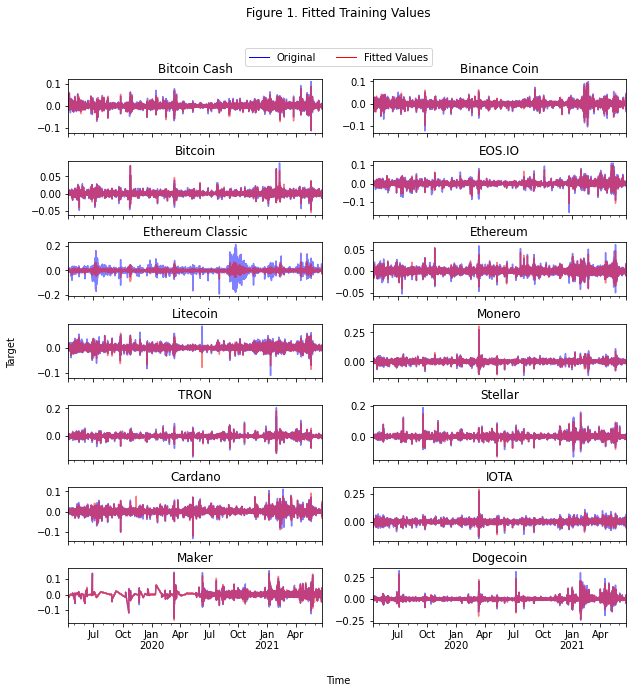

In [17]:
fig, axes = plt.subplots(nrows = int(len(asset_details_df)/2), ncols = 2, 
                         sharex = True, figsize = (10,10))
axes = axes.flatten()

color_one = "blue"
color_two = "red"
alpha = 0.5

for i, (ax, asset) in enumerate(zip(axes, asset_details_df["Asset_ID"])):
    print(i)
    col_string = "Target_" + str(asset)
    temp_df.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_one, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    temp_fit.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_two, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    
fig.suptitle("Figure 1. Fitted Training Values")
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Target', va='center', rotation='vertical')
fig.subplots_adjust(hspace=.5)

# create custom legend
handles = [Line2D([0], [0], color = color_one, lw = 1, label = 'Original'),
           Line2D([0], [0], color = color_two, lw = 1, label = 'Fitted Values')]

fig.legend(handles = handles, loc = "center", bbox_to_anchor=(0.5, 0.91), ncol = 2)

plt.savefig("train.png")    
plt.show()

In [18]:
del fig
del axes
del temp_df
del temp_fit

gc.collect()

49

## Make Forecasts and Evaluate

In [19]:
forecast_list = []

for i, (fit_result, standard_test_dep_df, standard_test_ex_df) in enumerate(zip(fit_results_list, standard_test_dep_df_list, standard_test_ex_df_list)):
    exog_variables = standard_test_ex_df.merge(standard_test_dep_df.drop(
                                                labels = standard_test_dep_df.columns[i], 
                                                axis = 1),
                                            how = "left",
                                            left_index = True, right_index = True)

    forecasts = fit_result.forecast(steps = len(standard_test_dep_df),
                                    exog = exog_variables)
    forecast_list.append(forecasts)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages

In [20]:
forecast_list[0]

1155430    0.003081
1155431    0.002379
1155432    0.001875
1155433    0.001726
1155434    0.001718
             ...   
1285026    0.000656
1285027    0.000640
1285028    0.000578
1285029    0.000457
1285030    0.000339
Length: 129601, dtype: float64

In [21]:
forecast_df = pd.DataFrame(data = {column : data 
                                   for column, data 
                                   in zip(standard_test_dep_df.columns, forecast_list)}
                          )

forecast_df

,Target_2,Target_0,Target_1,Target_5,Target_7,Target_6,Target_9,Target_11,Target_13,Target_12,Target_3,Target_8,Target_10,Target_4
1155430,0.003081,0.014077,-0.002422,0.000168,-0.003746,0.001619,0.002015,-0.005794,0.001900,0.004030,0.005503,0.013354,0.013662,-0.007338
1155431,0.002379,0.012614,-0.002273,0.000227,-0.004492,0.001151,0.001552,-0.004032,0.001709,0.003530,0.004838,0.009642,0.013483,-0.007370
1155432,0.001875,0.011160,-0.002149,0.000305,-0.002650,0.000795,0.001090,-0.003340,0.001497,0.003161,0.004287,0.007707,0.013299,-0.007029
1155433,0.001726,0.009927,-0.001953,0.000500,-0.002704,0.000663,0.000842,-0.003093,0.001349,0.002885,0.003713,0.005976,0.013166,-0.006855
1155434,0.001718,0.008700,-0.001641,0.000747,-0.002975,0.000674,0.000875,-0.003296,0.001253,0.002511,0.003157,0.004022,0.013042,-0.006791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1285026,0.000656,0.001097,0.000388,0.000899,-0.002149,0.000799,-0.000017,0.003625,0.000867,0.001017,0.001205,0.002033,-0.001024,0.001352
1285027,0.000640,0.000869,0.000336,0.000569,-0.002852,0.000826,-0.000140,0.003020,0.000663,0.000687,0.000824,0.001137,-0.001075,0.000988
1285028,0.000578,0.000669,0.000311,0.000334,-0.003134,0.000840,-0.000236,0.002511,0.000505,0.000412,0.000495,0.000488,-0.001101,0.000669
1285029,0.000457,0.000700,0.000314,0.000235,-0.004192,0.000820,-0.000327,0.002845,0.000449,0.000442,0.000445,0.001271,-0.001003,0.000325


In [22]:
del forecast_list
gc.collect()

69

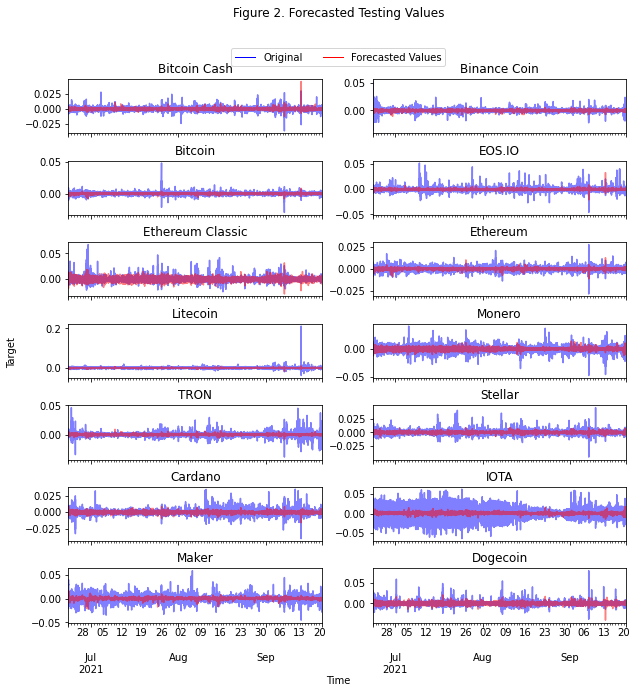

In [23]:
temp_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) <= cutoff_timestamp].copy()
temp_df.loc[:, "datetime"] = pd.to_datetime(temp_df.loc[:, "timestamp"].values, 
                                                unit = "s", infer_datetime_format = True)

temp_fit = forecast_df.copy()
temp_fit.loc[:, "datetime"] = temp_df.loc[:, "datetime"].values.copy()

num = 4
temp_df = temp_df.iloc[::num, :]
temp_fit = temp_fit.iloc[::num, :]

fig, axes = plt.subplots(nrows = int(len(asset_details_df)/2), ncols = 2, 
                         sharex = True, figsize = (10,10))
axes = axes.flatten()

color_one = "blue"
color_two = "red"
alpha = 0.5

for i, (ax, asset) in enumerate(zip(axes, asset_details_df["Asset_ID"])):
    col_string = "Target_" + str(asset)
    temp_df.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_one, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    temp_fit.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_two, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    
fig.suptitle("Figure 2. Forecasted Testing Values")
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Target', va='center', rotation='vertical')
fig.subplots_adjust(hspace=.5)

# create custom legend
handles = [Line2D([0], [0], color = color_one, lw = 1, label = 'Original'),
           Line2D([0], [0], color = color_two, lw = 1, label = 'Forecasted Values')]

fig.legend(handles = handles, loc = "center", bbox_to_anchor=(0.5, 0.91), ncol = 2)

plt.savefig("test.png")    
plt.show()

In [24]:
del temp_df
del temp_fit
gc.collect()

58801